# Visualisation of post and comments structure

#### 1. Documentation
- <http://madebyideguchi.blogspot.com/2014/01/networkx-working-with-graphs-in-python.html>
- <https://medium.com/@gbrnc28/random-walk-method-page-rank-algorithm-using-networkx-7da8696ecc38>
- <https://spyhce.com/blog/python-networkx-library>
- <https://epidemicsonnetworks.readthedocs.io/en/latest/>
- <https://github.com/mihaigociu/myrepo/blob/master/networkx_presentation.py>

#### 2. Examples
- <>

Libraries

In [1]:
# database management
import sqlite3
import pandas as pd
import numpy as np 

# networkx
import networkx as nx
import networkx.algorithms.community as nxcom

# igraph
import igraph
from igraph import Graph

# draw
import matplotlib.pyplot as plt
import seaborn as sns

# technical
import operator
import random as rd
from functools import reduce

sns.set_style('whitegrid')

## 1. Data preparation

In [2]:
# 1. Extracting and preparing the dataset:
conn = sqlite3.connect('Data/obama_election.db')
# 2. Full dataset
df_obama = pd.read_sql('''SELECT author, parent_author
                            FROM Reddit
                            where month = 10''', conn) 
df_obama

author parent_author
0                gkiltz   TehSoupNazi
1       thelordofcheese  zabimaru1000
2          IAmABearAMAA   GiantSquidd
3               acm2033      hobofats
4             [deleted]       kjay227
...                 ...           ...
222059    cyress_avitus       Kishara
222060     Cum_Box_Hero       Kishara
222061       Obersts001       Kishara
222062          Kishara       Kishara
222063          Kishara       Kishara

[222064 rows x 2 columns]

In [3]:
# 1. Extracting and preparing the dataset:
conn = sqlite3.connect('Data/trump_election.db')
# 2. Full dataset
df_trump = pd.read_sql('''SELECT author, parent_author
                            FROM Reddit
                            where month = 10''', conn) 
df_trump

author     parent_author
0              JuicyJuuce            Dyna82
1                  Dyna82        JuicyJuuce
2        TheLightningbolt        mindbleach
3              mindbleach  TheLightningbolt
4        TheLightningbolt        flippydude
...                   ...               ...
429129         formeraide       myellabella
429130  rafikiknowsdeway1       myellabella
429131         satosaison       myellabella
429132      AutoModerator       myellabella
429133        myellabella       myellabella

[429134 rows x 2 columns]

## 2. Graph creation

In [4]:
def graph_creator(df_in, n_conn):
    
    """
    The function prepares a networkx graph while keeping spaecified number od connections.

    Parameters:
        df_in: dataframe containing source and target nodes 
        n_conn (int): minimum number of connections a pair of nodes should have
        
    Returns:
        G: networkx graph 
    """
    
    #===============================================================================
    # Data
    df = df_in[(~df_in['author'].isin(['[deleted]','None']))  &  (~df_in['parent_author'].isin(['[deleted]','None'])) ]

    #===============================================================================    
    # graph
    G_all=nx.from_pandas_edgelist(df, source='parent_author', target='author', create_using=nx.DiGraph())
    
    # 1) select only bi-directional edges
    selected_edges = []
    for u,v in G_all.edges():
        # check if bi-directional
        if G_all.has_edge(u, v) == G_all.has_edge(v, u):
            selected_edges.append((u,v))         
            
    # undirected graph        
    H = nx.Graph()
    H.add_edges_from(selected_edges)
    
    # 2. keep only nodes that engaed creating a count attribute
    nx.set_edge_attributes(H, 0, "count")
    for source, target in df.itertuples(index=False):
        if H.has_edge(source, target) == True:
            H.edges[source, target]['count'] +=1
            
    # keep only those edges that occurr 3 or more times 
    selected_edges = [(u,v) for u,v,e in H.edges(data=True) if e['count']  >= n_conn]
    G_sub = H.edge_subgraph(selected_edges)
    
    # removing disconnected nodes
    sub_list = max(nx.connected_components(G_sub), key=len)
    G = G_sub.subgraph(sub_list)
    
    
    # position of nodes
    pos = nx.nx_pydot.graphviz_layout(G, prog='sfdp')
    #pos = nx.kamada_kawai_layout(G)
    
    return G, pos

In [5]:
G1, pos1 = graph_creator(df_obama, n_conn=4)
print(nx.info(G1))

Name: 
Type: Graph
Number of nodes: 2233
Number of edges: 2373
Average degree:   2.1254


In [6]:
G2, pos2 = graph_creator(df_trump, n_conn=5)
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 3329
Number of edges: 3552
Average degree:   2.1340


## 3. Exploring the properties

In [7]:
def graph_properties(G):
    
    properties_dict = {}

    #===============================================================================        
    # Graph properties
    properties_dict["diameter"] = nx.diameter(G)
    properties_dict["average_shortest_path_length"] = nx.average_shortest_path_length(G)
    properties_dict["triangles"] = len(nx.triangles(G))
    properties_dict["clustering"] = nx.average_clustering(G)
    properties_dict["transitivity"] = nx.transitivity(G)
    properties_dict["density"] = nx.density(G)
    properties_dict["global_efficiency"] = nx.global_efficiency(G)
    
    return properties_dict

In [8]:
properties1 = graph_properties(G1)

In [9]:
properties2 = graph_properties(G2)

In [10]:
print(properties1)

{'diameter': 29, 'average_shortest_path_length': 9.795216987931115, 'triangles': 2233, 'clustering': 0.0017157850856910416, 'transitivity': 0.0024330900243309003, 'density': 0.0009522364917248121, 'global_efficiency': 0.11629819252329446}


In [11]:
print(properties2)

{'diameter': 26, 'average_shortest_path_length': 10.414733865563694, 'triangles': 3329, 'clustering': 0.000411248909296371, 'transitivity': 0.00025134048257372655, 'density': 0.0006412181990433718, 'global_efficiency': 0.10637554592738956}


## 4. Detecting communities

In [12]:
def set_node_community(G, communities):
    """
    Assigning communities to nodes

    Parameters:
        G: networkx graph
        
    Returns:
        G: networkx graph 
        node_color: list of availiable colors
        node_community: dictionary of colora assigned to nodes
    """
    node_color = []
    node_community = {}
    for i, com in enumerate(communities):
        for v in com:
            G.nodes[v]['community'] = i + 1
            node_color.append(get_color(i, n=len(communities)))
            node_community[v] = i
            
    return node_color, node_community, G

In [13]:
def set_edge_community(G):
    """
    Assigning communities to egdes between nodes of same community

    Parameters:
        G: networkx graph
    
    Returns:
        rgb tuple
    """
    
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

In [14]:
def get_color(i, n, r_off=1, g_off=1, b_off=1):
    """
    Color generator for communities

    Parameters:
        G: networkx graph
        pos: dictionary of positions for the nodes
        
    """
    
    r0, g0, b0 = 0, 0, 0
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [15]:
def community_plot(G, pos):
    
    """
    The function detects user communities and visualises them.

    Parameters:
        G: networkx graph
        pos: dictionary of positions for the nodes
    """
    
    
    #=============================================================================== 
    # Communty detection
    print("============================= Community detection ==================================")
    partition1=sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True) 
    print('CNM coverage:',    nxcom.coverage(G, partition1))
    print('CNM performance:', nxcom.performance(G, partition1))    
    print("CNM number of communities:", len(partition1) )
    
    print("-------------------------------------------------------------")   
    partition2=sorted(nxcom.asyn_lpa_communities(G), key=len, reverse=True) 
    print('LPA coverage:',    nxcom.coverage(G, partition2))
    print('LPA performance:', nxcom.performance(G, partition2))    
    print("LPA number of communities:", len(partition2) )
    
    print("-------------------------------------------------------------")   
    partition3=sorted(nxcom.asyn_fluidc(G, 10), key=len, reverse=True) 
    print('Fluids10 coverage:',    nxcom.coverage(G, partition3))
    print('Fluids10 performance:', nxcom.performance(G, partition3))           
    print("Fluids10 number of communities:", len(partition3) )
    
    print("-------------------------------------------------------------")   
    partition4=sorted(nxcom.asyn_fluidc(G, 20), key=len, reverse=True) 
    print('Fluids20 coverage:',    nxcom.coverage(G, partition4))
    print('Fluids20 performance:', nxcom.performance(G, partition4))         
    print("Fluids20 number of communities:", len(partition4) )
    
    print("-------------------------------------------------------------")           
    partition5=sorted(nxcom.asyn_fluidc(G, 40), key=len, reverse=True) 
    print('Fluids40 coverage:',    nxcom.coverage(G, partition5))
    print('Fluids40 performance:', nxcom.performance(G, partition5))       
    print("Fluids40 number of communities:", len(partition5) )

    print("===============================================================")
    
    communities = partition1
       
    #===============================================================================        
    #plot
    
    # Set node and edge communities
    node_color, node_community, G = set_node_community(G, communities)
    set_edge_community(G)
    
    # Set community color for nodes
    node_color = [get_color(G.nodes[v]['community'], n=len(communities)) for v in G.nodes]
    
    # Set community color for internal edges
    external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
    internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
    internal_color = [get_color(G.edges[e]['community'], n=len(communities)) for e in internal]    
    
    # plot
    fig = plt.figure(figsize=(70, 50))
    
    # Draw external edges
    nx.draw_networkx(G, pos=pos, node_size=0, edgelist=external, style="dashed", edge_color="lightgrey", with_labels=False)
    
    # Draw nodes and internal edges
    nx.draw_networkx(G, pos=pos, node_color=node_color, edgelist=internal, edge_color=internal_color, with_labels=False)


============================= Community detection ==================================
CNM coverage: 0.934260429835651
CNM performance: 0.9763124651889946
CNM number of communities: 46
-------------------------------------------------------------
LPA coverage: 0.6852085967130215
LPA performance: 0.9985252974685678
LPA number of communities: 612
-------------------------------------------------------------
Fluids10 coverage: 0.9464812473662031
Fluids10 performance: 0.8881613689733823
Fluids10 number of communities: 10
-------------------------------------------------------------
Fluids20 coverage: 0.9367888748419722
Fluids20 performance: 0.9327631952770996
Fluids20 number of communities: 20
-------------------------------------------------------------
Fluids40 coverage: 0.9245680573114201
Fluids40 performance: 0.9656913967258794
Fluids40 number of communities: 40


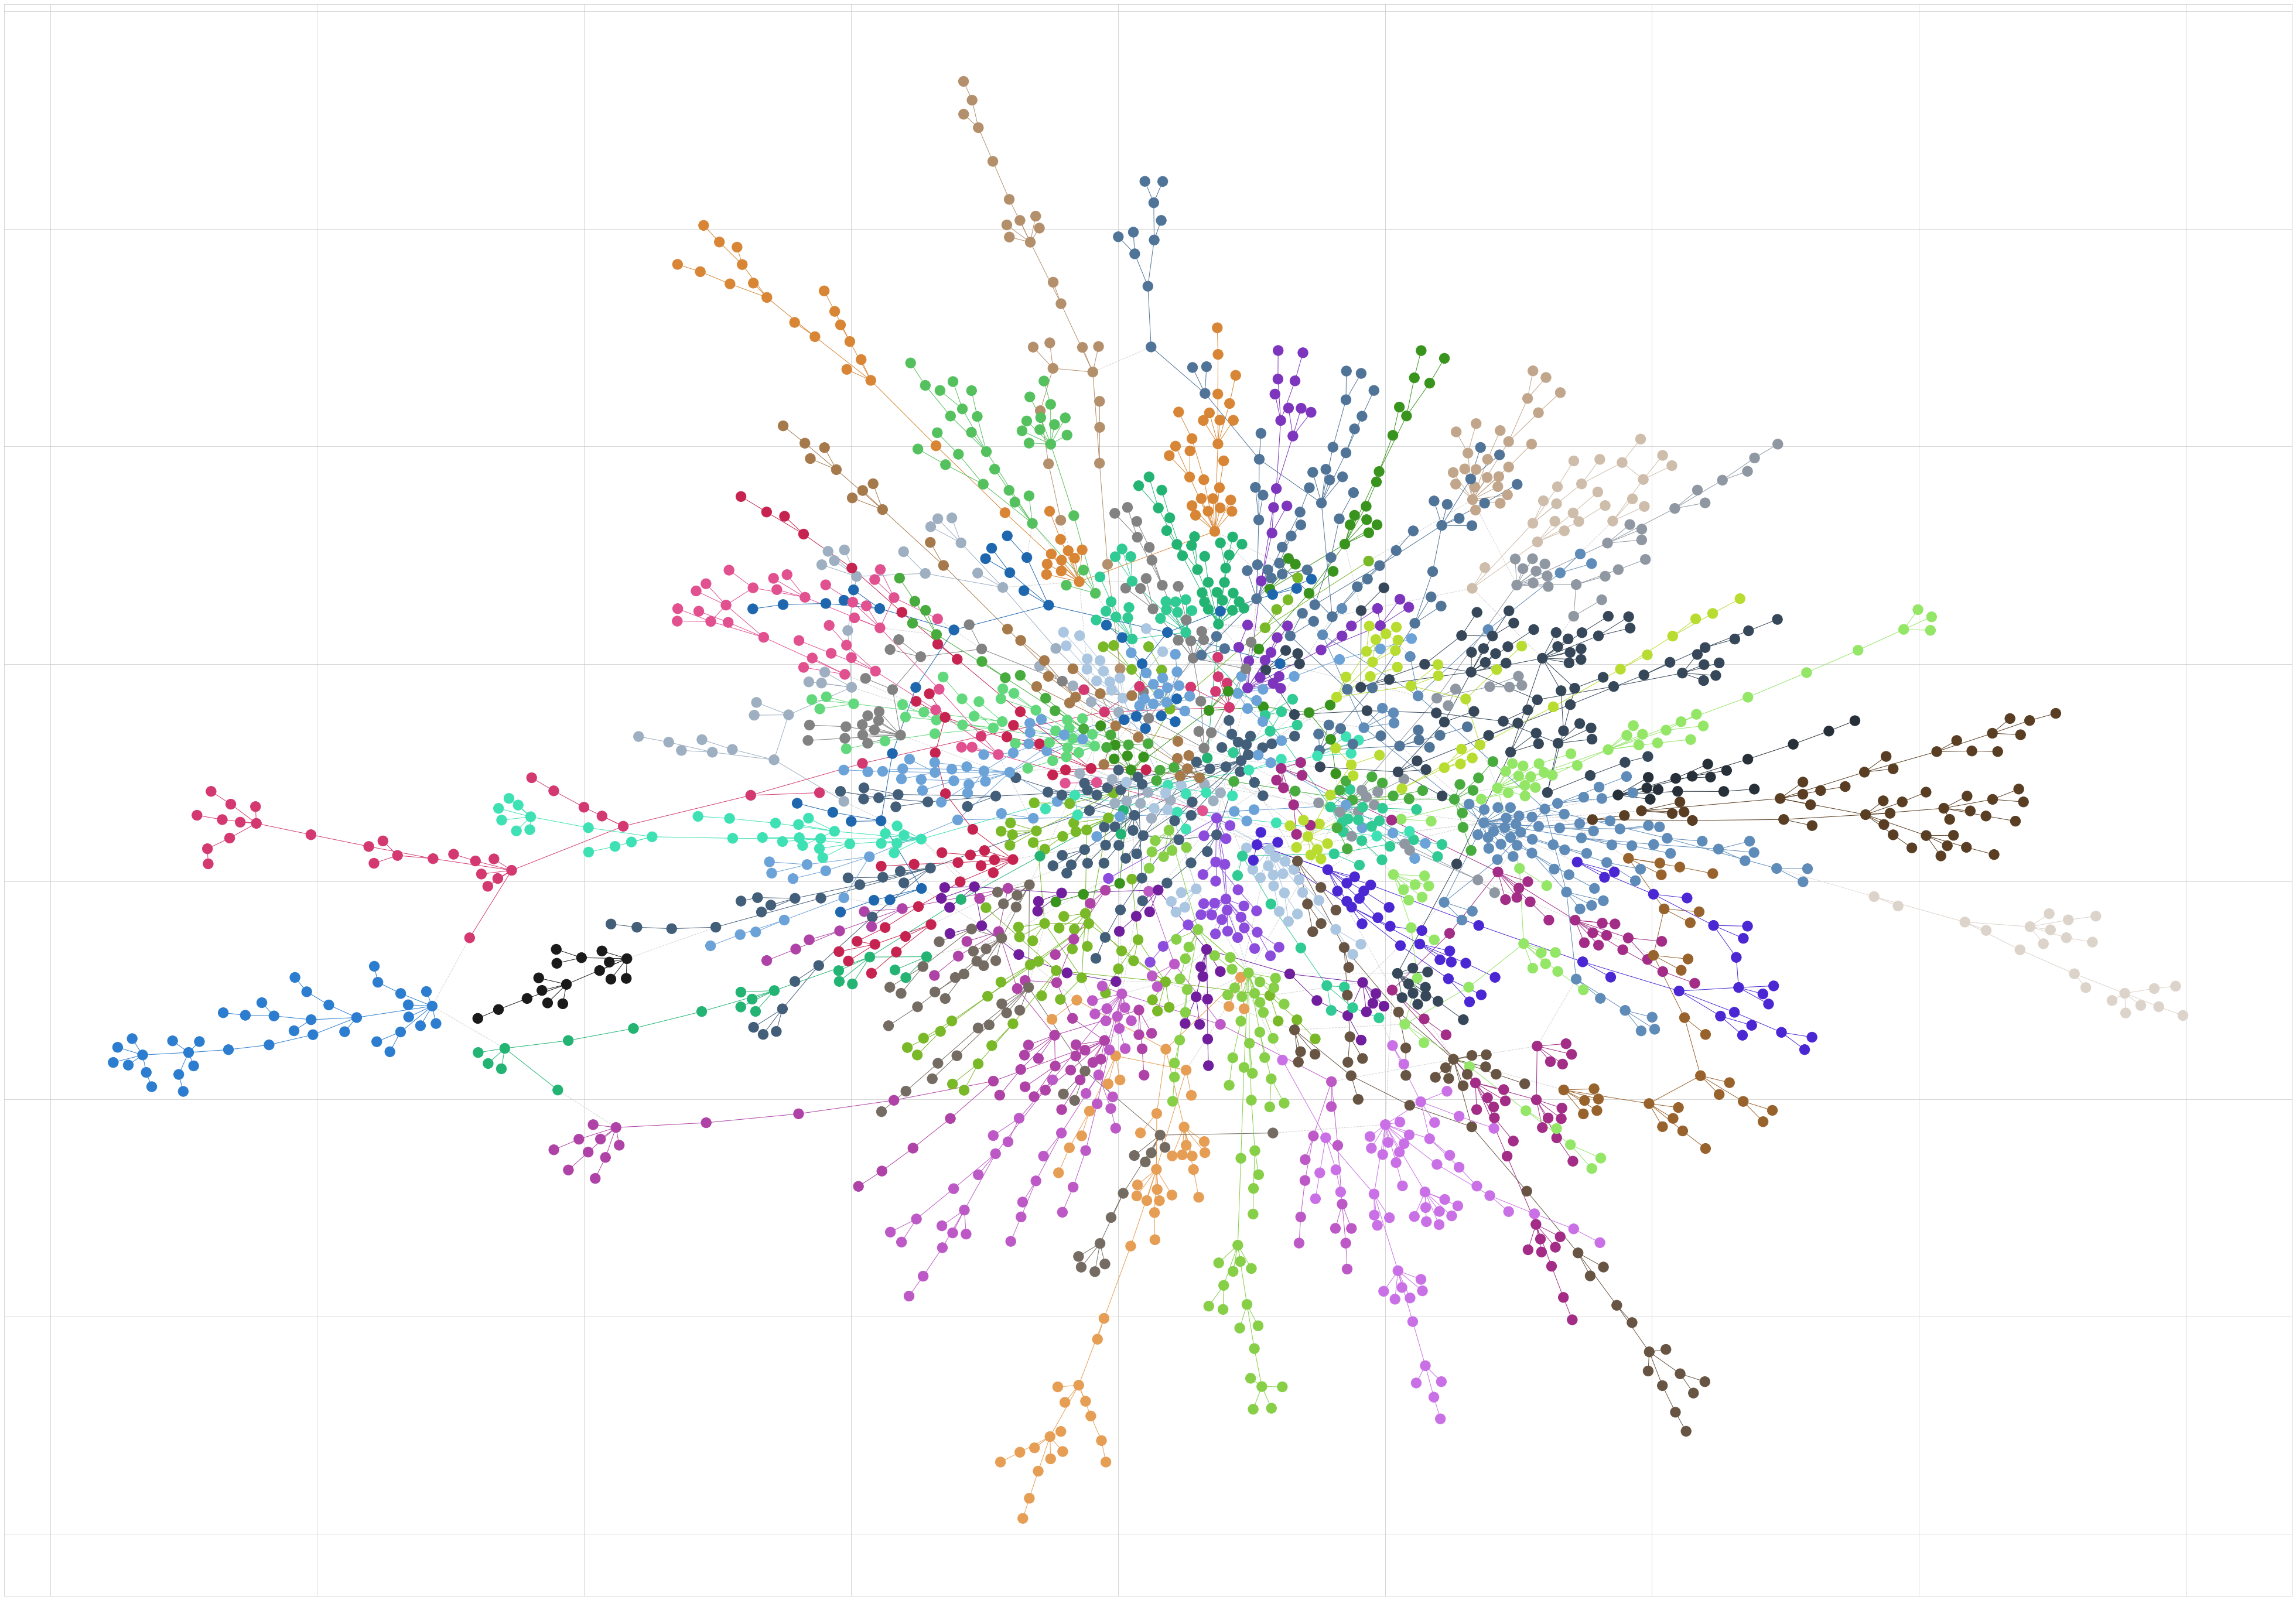

In [16]:
community_plot(G1, pos1)
plt.savefig(r'Visualisations/5_1_user_communities_2012.png', bbox_inches='tight')
plt.show()

============================= Community detection ==================================
CNM coverage: 0.9310247747747747
CNM performance: 0.9803908542643899
CNM number of communities: 54
-------------------------------------------------------------
LPA coverage: 0.6838400900900901
LPA performance: 0.9989782390184162
LPA number of communities: 904
-------------------------------------------------------------
Fluids10 coverage: 0.9414414414414415
Fluids10 performance: 0.8658503650900016
Fluids10 number of communities: 10
-------------------------------------------------------------
Fluids20 coverage: 0.9335585585585585
Fluids20 performance: 0.9375709455946577
Fluids20 number of communities: 20
-------------------------------------------------------------
Fluids40 coverage: 0.9228603603603603
Fluids40 performance: 0.9697854807403471
Fluids40 number of communities: 40


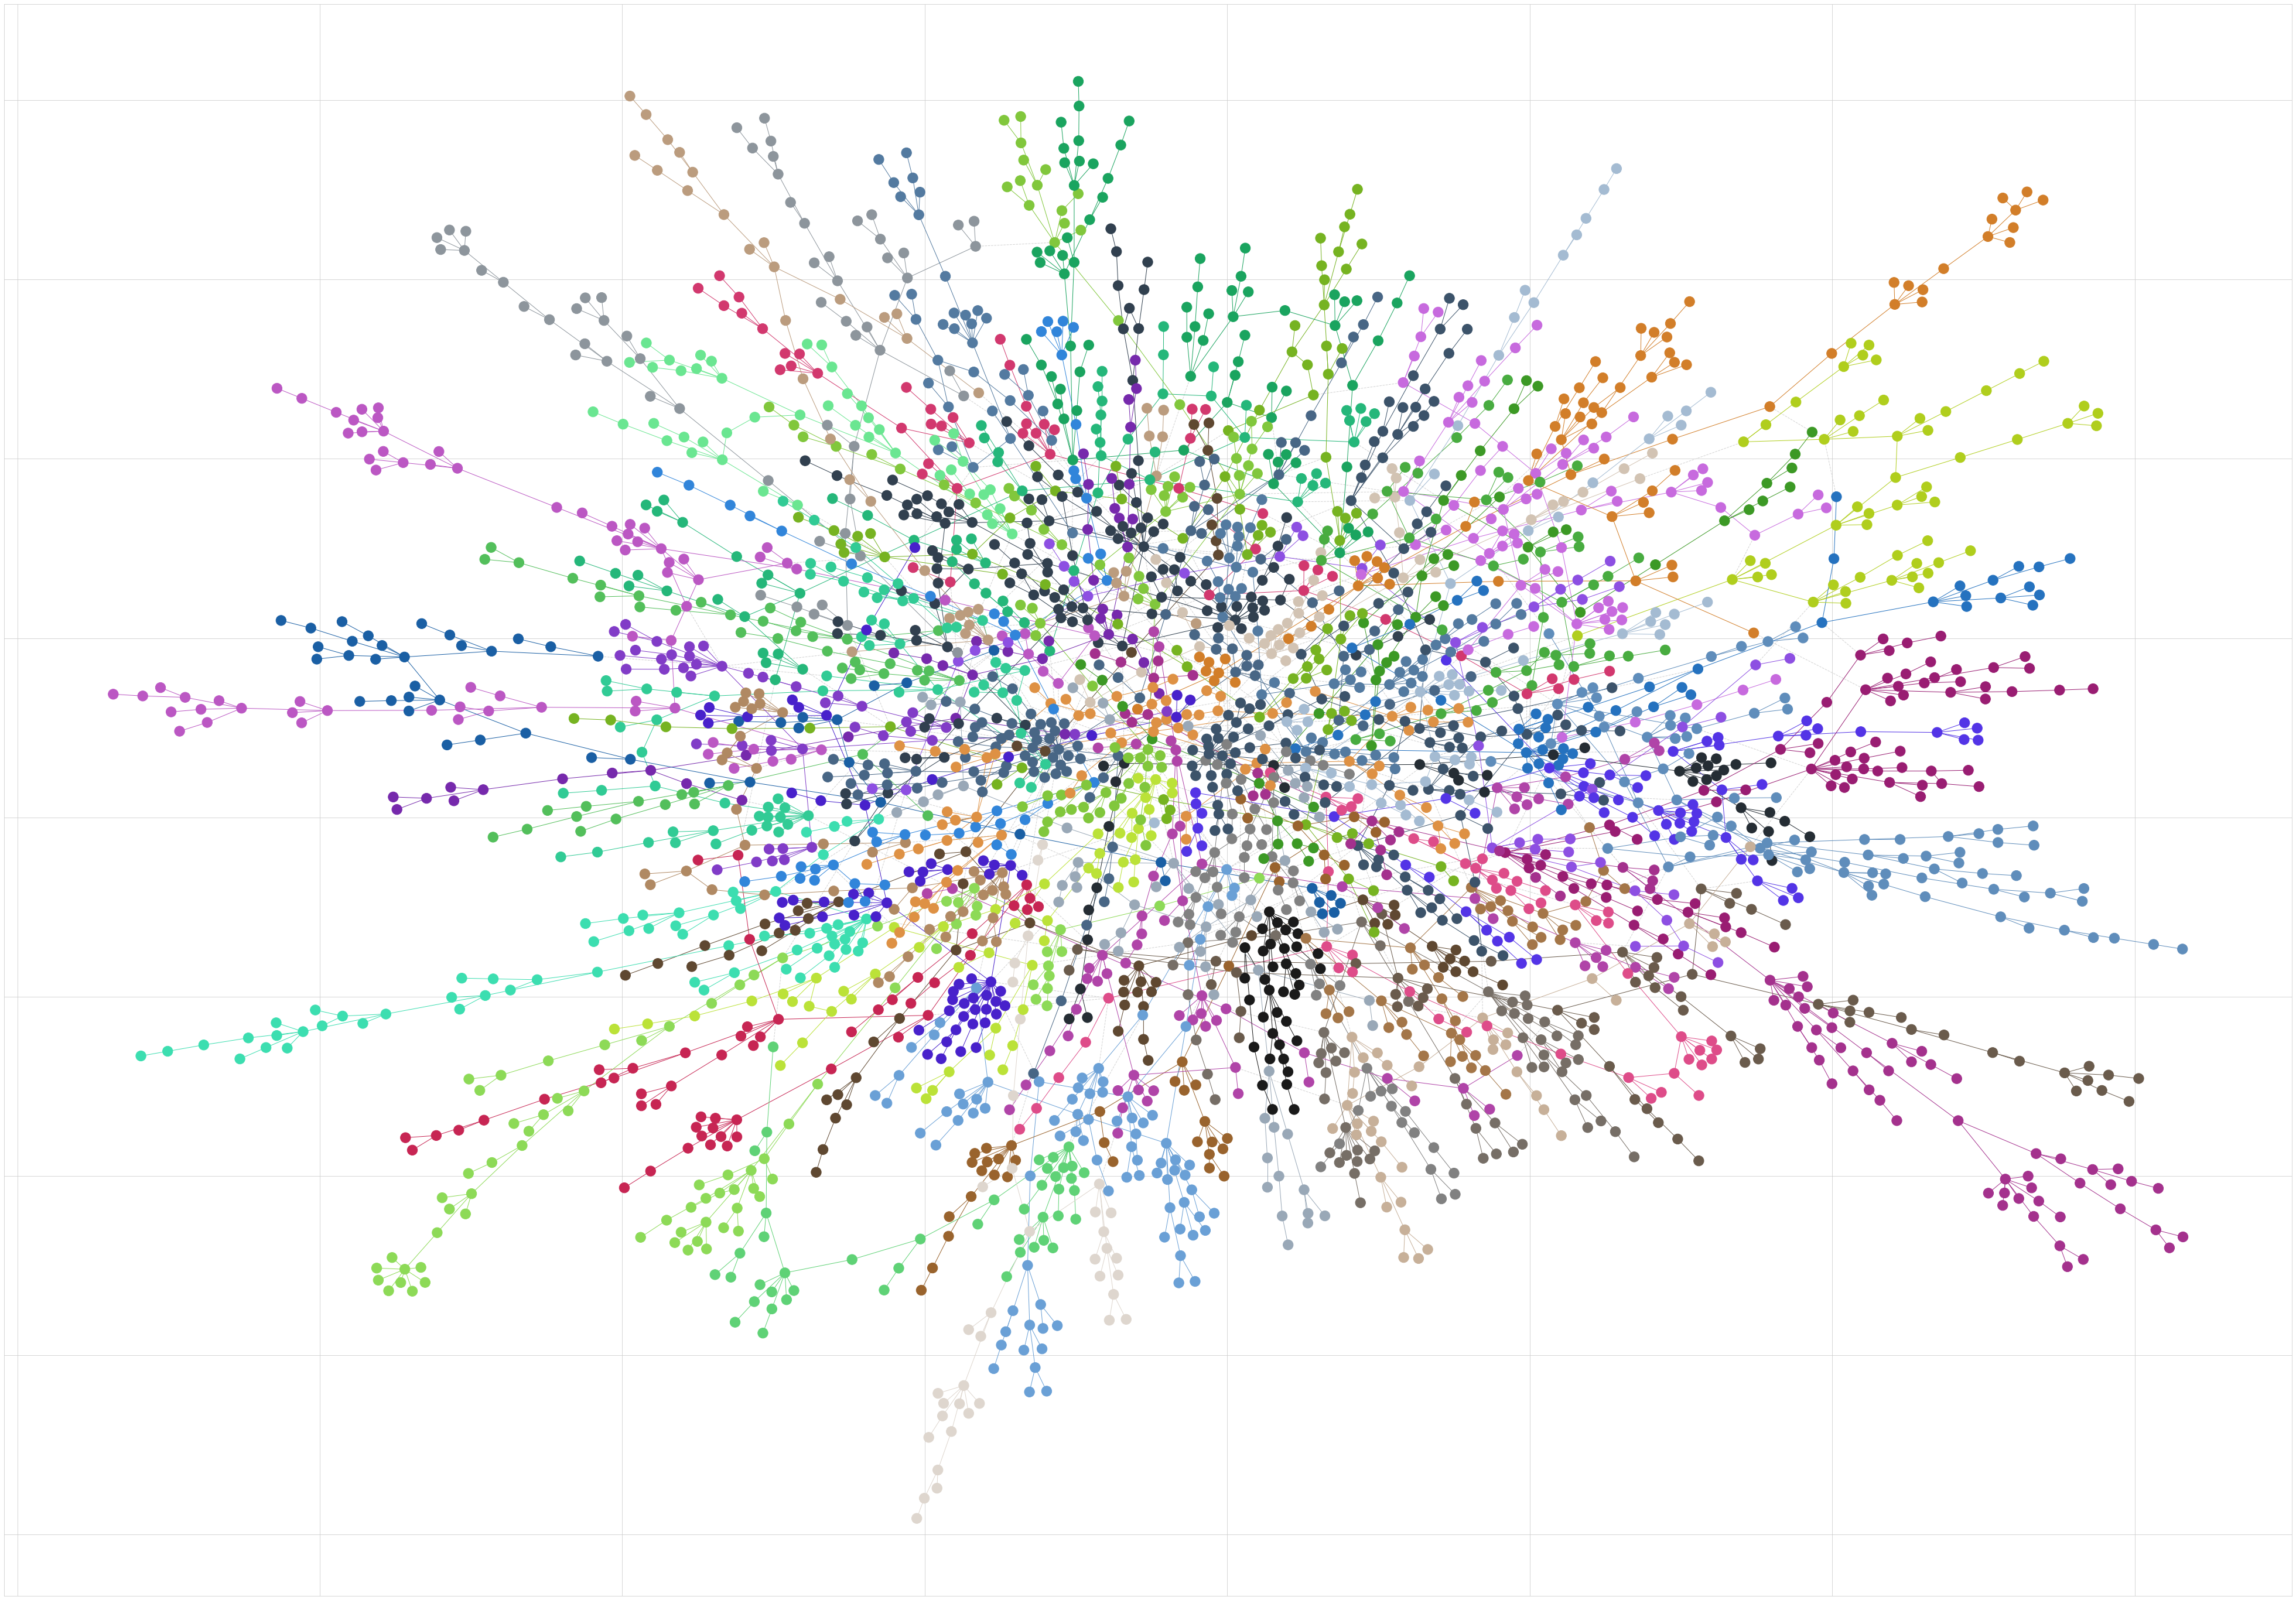

In [17]:
community_plot(G2, pos2)
plt.savefig(r'Visualisations/5_1_user_communities_2016.png', bbox_inches='tight')
plt.show()